<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [79]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
import plotly.express as px
from scipy.stats import chi2_contingency
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import pickle
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, Normalizer, LabelEncoder

In [80]:
data = pd.read_csv('data_clean_v1.csv')

In [3]:
data.head()

,Unnamed: 0,age,gender,country,education,role,experience_prog,programming_lang_c,experience_ml,industry,company_size,team_size,salary,country_group,company_size_g,team_size_g,salary_avg,role_group
0,1,50-54,Man,India,Bachelor’s degree,Other,5-10 years,2,5-10 years,Manufacturing/Fabrication,50-249 employees,3-4,25000-29999,India,Medium,Small,27500.0,Other
1,2,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,4,Under 1 year,Manufacturing/Fabrication,"1000-9,999 employees",1-2,60000-69999,Other,Large,Small,65000.0,Data Analyst
2,3,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,3,No experience,Academics/Education,"1000-9,999 employees",0,0-999,Other,Large,No team,500.0,Data Engineer
3,4,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,1,5-10 years,Academics/Education,"1000-9,999 employees",0,30000-39999,Other,Large,No team,35000.0,Data Scientist
4,5,45-49,Man,India,Doctoral degree,Other,< 1 years,3,10-20 years,Academics/Education,50-249 employees,5-9,30000-39999,India,Medium,Small,35000.0,Other


In [4]:
data = data.drop(['Unnamed: 0'], axis=1)

In [5]:
data_eu = data[data['country_group'] == 'Europe']

In [6]:
def boxcox_transform(data, skip_columns=[]):
    numeric_cols = data.select_dtypes(np.number).columns
    _ci = {column: None for column in numeric_cols}
    for column in numeric_cols:
        if column not in skip_columns:
# since i know any columns should take negative numbers, to avoid -inf in df
            data[column] = np.where(data[column]<=0, np.NAN, data[column]) 
            data[column] = data[column].fillna(data[column].mean())
            transformed_data, ci = stats.boxcox(data[column])
            data[column] = transformed_data
            _ci[column] = [ci] 
    return data, _ci

In [7]:
data_eu, _ci = boxcox_transform(data_eu, skip_columns = ['programming_lang_c'])
data_eu

,age,gender,country,education,role,experience_prog,programming_lang_c,experience_ml,industry,company_size,team_size,salary,country_group,company_size_g,team_size_g,salary_avg,role_group
10,35-39,Man,Greece,Doctoral degree,Research Scientist,10-20 years,4,4-5 years,Academics/Education,50-249 employees,5-9,10000-14999,Europe,Medium,Small,59.037439,Data Scientist
11,50-54,Man,Belgium,Bachelor’s degree,Data Analyst,20+ years,2,1-2 years,Energy/Mining,"1000-9,999 employees",5-9,2000-2999,Europe,Large,Small,34.263258,Data Analyst
17,25-29,Woman,Poland,Master’s degree,Machine Learning Engineer,3-5 years,2,Under 1 year,Computers/Technology,0-49 employees,3-4,25000-29999,Europe,Small,Small,76.612364,Data Engineer
24,25-29,Man,Italy,Master’s degree,Other,1-3 years,2,Under 1 year,Energy/Mining,0-49 employees,1-2,30000-39999,Europe,Small,Small,82.921494,Other
35,35-39,Woman,Russia,I prefer not to answer,Data Scientist,1-3 years,2,No experience,Academics/Education,"1000-9,999 employees",3-4,0-999,Europe,Large,Small,19.355640,Data Scientist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14345,30-34,Man,Portugal,Master’s degree,Data Engineer,10-20 years,4,5-10 years,Manufacturing/Fabrication,"1000-9,999 employees",20+,70000-79999,Europe,Large,Large,106.331076,Data Engineer
14348,25-29,Man,Germany,Master’s degree,Data Scientist,1-3 years,2,1-2 years,Computers/Technology,"10,000 or more employees",20+,60000-69999,Europe,Large,Large,101.495874,Data Scientist
14358,40-44,Man,Russia,I prefer not to answer,Data Engineer,< 1 years,2,Under 1 year,Computers/Technology,"10,000 or more employees",20+,0-999,Europe,Large,Large,19.355640,Data Engineer
14365,35-39,Man,Russia,Bachelor’s degree,Software Engineer,3-5 years,4,No experience,Insurance/Risk Assessment,250-999 employees,10-14,20000-24999,Europe,Large,Medium,71.716456,Data Engineer


In [8]:
def remove_outliers(data, threshold=1.5, in_columns=data.select_dtypes(np.number).columns, skip_columns=[]):
    for column in in_columns:
        if column not in skip_columns:
            upper = np.percentile(data[column],75)
            lower = np.percentile(data[column],25)
            iqr = upper - lower
            upper_limit = upper + (threshold * iqr)
            lower_limit = lower - (threshold * iqr)
            data = data[(data[column]>lower_limit) & (data[column]<upper_limit)]
    return data

In [9]:
data_eu = remove_outliers(data_eu, threshold=1.5)

In [10]:
def dist_boxplot_num(data, skip_columns=[]):
    for col in data.select_dtypes(np.number):
        if col not in skip_columns:
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))
            sns.distplot(data[col], ax=axes[0])
            sns.boxplot(data[col], ax=axes[1])
            plt.show()

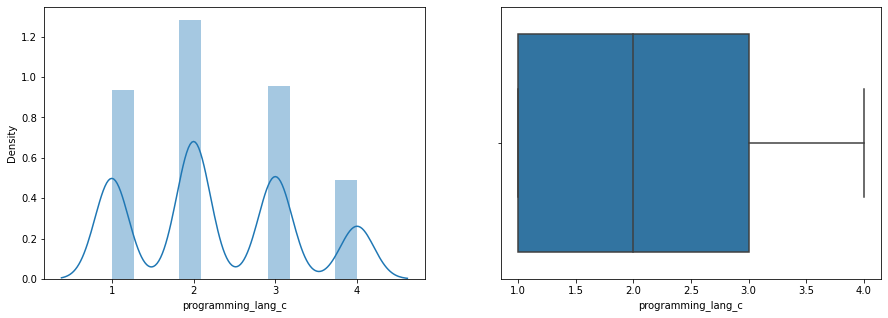

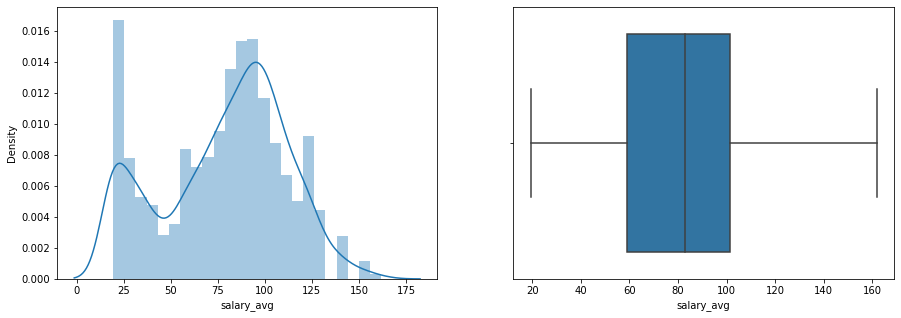

In [11]:
dist_boxplot_num(data_eu)

In [63]:
data_eu = data_eu.drop(['country_group','company_size', 'salary', 'team_size', 'role'], axis=1)

KeyError: "['country_group' 'company_size' 'salary' 'team_size' 'role'] not found in axis"

In [78]:
data_eu = data_eu['gender', 'salary_avg']

KeyError: ('gender', 'salary_avg')

In [65]:
X = data_eu.drop('salary_avg', axis=1)
y = data_eu['salary_avg']

In [66]:
X = pd.get_dummies(X)
X.head()

,programming_lang_c,age_18-21,age_22-24,age_25-29,age_30-34,age_35-39,age_40-44,age_45-49,age_50-54,age_55-59,...,industry_Non-profit/Service,industry_Online Business/Internet-based Sales,industry_Online Service/Internet-based Services,industry_Other,industry_Retail/Sales,industry_Shipping/Transportation,role_group_Data Analyst,role_group_Data Engineer,role_group_Data Scientist,role_group_Other
10,4,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
11,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
17,2,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
24,2,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
35,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [68]:
clf = RandomForestRegressor(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.14974273113002867


In [69]:
# Use the forest's predict method on the test data
predictions = clf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 24.45 degrees.


In [70]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 41.46 %.


In [71]:
clf = RandomForestRegressor(random_state=0, max_features='sqrt', min_samples_leaf=1,min_samples_split=5, max_depth=14, n_estimators=200)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.339581152261646


In [20]:
# Use the forest's predict method on the test data
predictions = clf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 20.03 degrees.


In [21]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 51.22 %.


In [22]:
X_train_num = X_train.select_dtypes(np.number)
X_test_num = X_test.select_dtypes(np.number)

In [54]:
X_train_num_ = X_train.select_dtypes(np.number)
X_test_num_ = X_test.select_dtypes(np.number)

In [55]:
transformer = StandardScaler()
transformer.fit(X_train_num_)

# saving in a pickle
with open('std_transformer.pickle', 'wb') as file:
    pickle.dump(transformer, file)
    
# loading from a pickle  
with open('std_transformer.pickle', 'rb') as file:
    loaded_transformer = pickle.load(file)

X_train_std = loaded_transformer.transform(X_train_num_)
X_test_std = loaded_transformer.transform(X_test_num_)

In [25]:
#With normalizer


transformer = Normalizer()
transformer.fit(X_train_num)


# saving in a pickle
with open('nm_transformer.pickle', 'wb') as file:
    pickle.dump(transformer, file)
    
# loading from a pickle  
with open('nm_transformer.pickle', 'rb') as file:
    loaded_transformer = pickle.load(file)

X_train_ = loaded_transformer.transform(X_train_num)
X_test_ = loaded_transformer.transform(X_test_num)

In [47]:
clf = RandomForestRegressor(random_state=42, max_features='auto', min_samples_leaf=1,min_samples_split=2, max_depth=14, n_estimators=200)
clf.fit(X_train_, y_train)
print(clf.score(X_test_, y_test))

0.38523476188594596


In [57]:
clf = RandomForestRegressor(random_state=42, max_features='auto', min_samples_leaf=1,min_samples_split=2, max_depth=14, n_estimators=200)
clf.fit(X_train_std, y_train)
print(clf.score(X_test_std, y_test))

0.3971545814948153


In [60]:
# Use the forest's predict method on the test data
predictions = clf.predict(X_test_std)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 19.82 degrees.


In [61]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 52.56 %.
